# RRTMG on Keeling 

In today's class, we will use this notebook to work on Atmospheric Science application problems with the RRTMG model. We'll break the class down into two main parts: 
1. 

By the end of the class, you will know: 
1. What are the minimum input you need to load into the RRTMG model;
2. What the output of the RRTMG model would look like

# Part I: Calculating Radiative Fluxes and Heating Rates  

RRTMG is one of the packages installed in a global climate model, where the domain (surface area) they cover include the entire Earth. For the first part in class, we'll look at how the heating rates and radiative fluxes would look like if we loaded different input into the model. 

To do so, we will be looking at simulated temperature profiles from the Community Earth System Model (CESM) version and observed data collected from [radiosonde data by the University of Wyoming](https://weather.uwyo.edu/upperair/sounding.html). We'll look at **two (?)** locations, San Deigo, CA, for its location that is close to the eastern Pacific stratocumulus deck; and Lincoln, IL, for its proximity to the University of Illinois, Urbana-Champaign. 

## A. Working with CESM Simulations in the RRTMG Model 

Climate models describes the various earth system processes by comprising of multiple components, including the atmospehric component, land, ocean, sea ice etc.. In the case of CESM model, the atmosphere is ran in the Community Atmosphere Model (CAM), where the latest version is version 6, and commonly known as CAM6 in CESM version 2. This component is also where the RRTMG model resides in. However, the output we'll be looking at is ran on CESM-1 CAM5, which is an older version, but the differences between the climate models are outside the scope of this tutorial, and the RRTMG model has no difference between the two CESM versions. (**need confirmation**)

To get the RRTMG model running in Climlab, we will need to let the model know what the initial conditions of the atmosphere we want to simulate be like - mainly the **temperature** and **water vapor profiles**. 
1. **Temperature:** Climlab has [`climlab.column_state()`](https://climlab.readthedocs.io/en/latest/api/climlab.domain.initial.html), which is a convenient routine that set the temperature profile by getting the arguments of the pressure levels (i.e. height axis). For CESM1 models, they are ran on a vertical profile of 26 atmospheric layers in all locations. 
2. **Water Vapor**: We will be loading the humidity profile from a coupled* aquaplanet** model run on CESM-1 CAM5. 

#### <u>On the side: More about the dataset that we are looking at</u>
**1. What is coupled?**
   
All Earth processes interact with each other: for example, winds in the atmosphere may advect sea surface temperatures, which is an example of the atmosphere communicating with the ocean. With the multiple components in a climate model, the components communicate with each other through a coupler, a software that controls the execution and time evolution of systems (tehcnical details can be found [here](https://www.cesm.ucar.edu/models/cpl)). When all components are allowed to run based on their model dynamics, and then communicate with each other before moving on to the next step in time, this is what we called as fully coupled. However, it is not required that all components to be active in a single run. For example, the ocean and sea ice components can be turned off, and the atmosphere takes known data that is loaded by the user (e.g. observational records of sea surface temperatures like measurements from [Argo floats](https://argo.ucsd.edu/about/status/)) to conduct calculations and return output. This practice is commonly called as prescribed SSTs, and the simulations are referred as Atmosphere-only model runs. It is beneficial as it is computationally cheaper than a fully coupled model, and the field has a standard experiment known as the Atmospheric Model Intercomparison project (AMIP) so as to investigate model diagnosis, validation and data acess etc.. 

In the dataset that we are looking at, we are looking at a fully coupled simulation. 

**2. What is an aquaplanet?**

### 1. Make Water Vapor Profile

### Step 0. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
import matplotlib.offsetbox as offsetbox
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from __future__ import division, print_function, absolute_import
import numpy as np
import warnings
from climlab import constants as const
from climlab.radiation.radiation import _Radiation_SW
from climlab.radiation.rrtm.utils import _prepare_general_arguments
from climlab.radiation.rrtm.utils import _climlab_to_rrtm, _climlab_to_rrtm_sfc, _rrtm_to_climlab
from inclass_func import *


warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

/data/keeling/a/rytam2/miniconda3/envs/rrtmg/lib/python3.11/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [2]:
#  Load the model output and check it out 
cesm_Q = xr.open_dataarray('../Data/cesm_Q.nc')
q_sandiego = xr.open_dataset('../Data/sd_q.nc') # load data here 

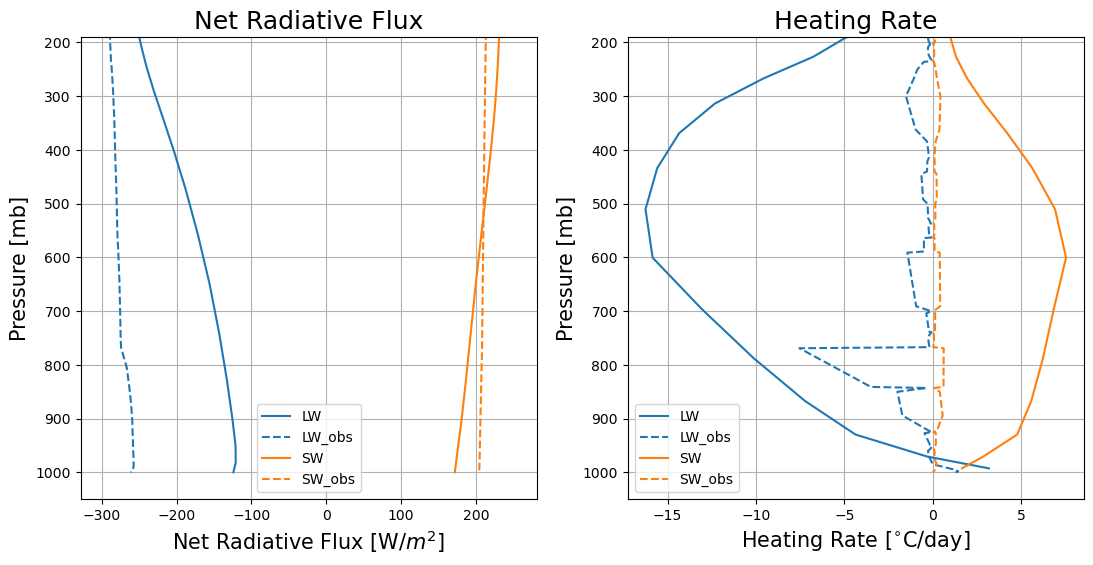

In [4]:
# Now we check out what the vertical profile of the net radiative fluxes and heating rate under this water vapor profile would look like 

rad_LW_cesm, rad_SW_cesm = model_setup(cesm_Q.values, cesm_Q.lev)
rad_sandiego_LW, rad_sandiego_SW = model_setup(q_sandiego.q.values/1000, list(reversed(q_sandiego.lev.values)))

# First we do the calculations
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))

ax1.plot(rad_LW_cesm.LW_flux_net*-1, rad_LW_cesm.lev_bounds, label='LW')
ax1.plot(rad_sandiego_LW.LW_flux_net*-1, rad_sandiego_LW.lev_bounds, label='LW_obs',linestyle="--", c='C0')
ax1.plot(rad_SW_cesm.SW_flux_net, rad_SW_cesm.lev_bounds, label='SW')
ax1.plot(rad_sandiego_SW.SW_flux_net, rad_sandiego_SW.lev_bounds, label='SW_obs',linestyle="--", c='C1')
#ax1.plot() # net green minus
ax1.invert_yaxis()
#maxval = np.max((radmodel_LW.LW_flux_net[3:], radmodel_SW.SW_flux_net[3:]))
#minval = np.min((radmodel_LW.LW_flux_net[3:], radmodel_SW.SW_flux_net[3:]))
ax1.set_ylim(top=190)
ax1.set_xlabel('Net Radiative Flux [W/$m^{2}$]',size=15)
ax1.set_ylabel('Pressure [mb]',size=15)
ax1.legend()
ax1.grid()
ax1.set_title('Net Radiative Flux',size=18)

ax2.plot(rad_LW_cesm.heating_rate['Tatm'], rad_LW_cesm.lev, label='LW')
ax2.plot(rad_sandiego_LW.heating_rate['Tatm'], rad_sandiego_LW.lev, label='LW_obs',linestyle="--",c='C0')
ax2.plot(rad_SW_cesm.heating_rate['Tatm'], rad_SW_cesm.lev, label='SW')
ax2.plot(rad_sandiego_SW.heating_rate['Tatm'], rad_sandiego_SW.lev, label='SW_obs',linestyle="--", c='C1')
ax2.plot() # net green minus
ax2.invert_yaxis()
maxval = np.max((rad_LW_cesm.heating_rate['Tatm'][3:], rad_SW_cesm.heating_rate['Tatm'][3:])) #max)
minval = np.min((rad_LW_cesm.heating_rate['Tatm'][3:], rad_SW_cesm.heating_rate['Tatm'][3:])) #max)
ax2.set_ylim(top=190)
ax2.set_xlim(minval-1, maxval+1)
ax2.set_xlabel('Heating Rate [$^{\circ}$C/day]',size=15)
ax2.set_ylabel('Pressure [mb]',size=15)
ax2.legend()
ax2.grid()
ax2.set_title('Heating Rate',size=18)
plt.savefig('/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Supplementary/notebook_images/sandiego_obsandsim.png',bbox_inches='tight')

# B. Working with Observational Data in the RRTMG Model
Next, we'll be loading humidity data from observations! We'll be using radiosonde data compiled by the University of Wyoming. 

We are gonna check out **N** locations, and compare it with simulation data. 

First up, San Diego, cuz it is cool. 

### San Diego
data brought to you by NKX San Diego.

In [4]:

q_sandiego

<xarray.Dataset>
Dimensions:  (lev: 124, q: 124)
Coordinates:
  * lev      (lev) float32 1e+03 998.0 995.0 985.0 974.0 ... 12.0 11.7 11.0 10.4
  * q        (q) float32 4.747 4.827 4.708 4.529 4.351 ... 0.02 0.02 0.02 0.02
Data variables:
    *empty*

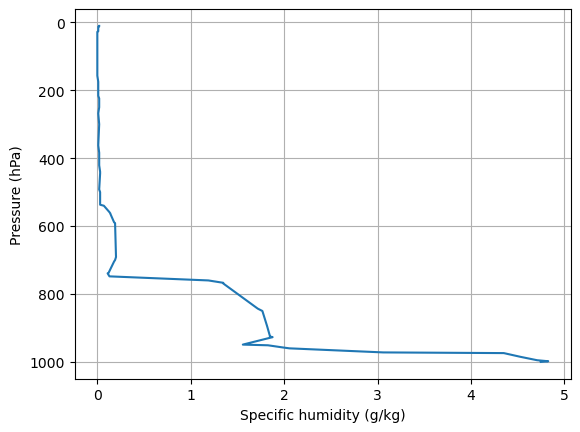

In [5]:
plot_humidity(q_sandiego.q, q_sandiego.lev)

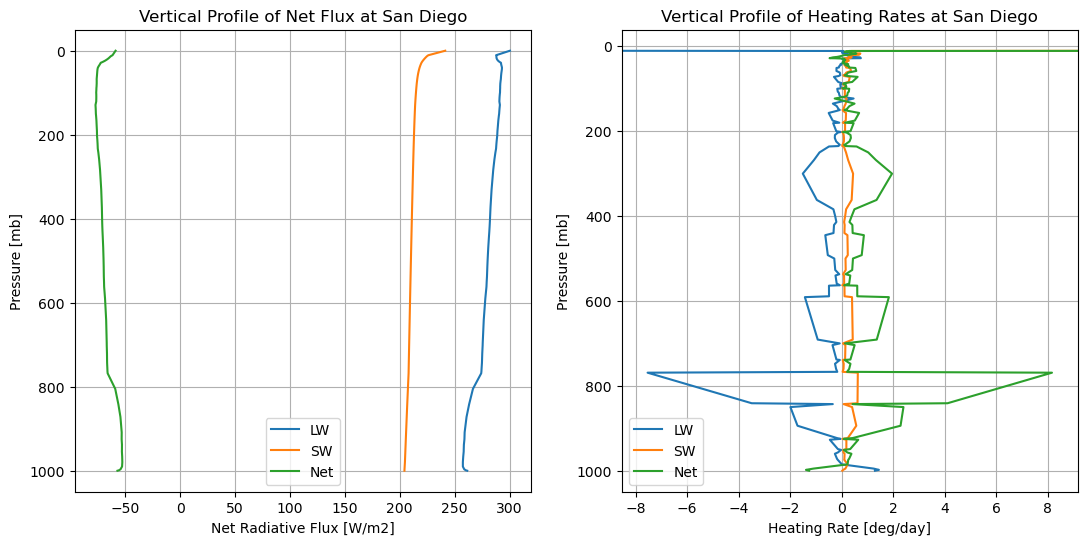

In [6]:
rad_sandiego_LW, rad_sandiego_SW = model_setup(q_sandiego.q.values/1000, list(reversed(q_sandiego.lev.values)))
plotting_clr(rad_sandiego_LW, rad_sandiego_SW,'San Diego')

### Lincoln 
Next up, Lincoln, IL, cuz it is close to home. Data credit to ILX Lincoln. 

In [7]:
q_lincoln = xr.open_dataset('Data/linil_q.nc')
plot_humidity(q_lincoln.q, q_lincoln.lev)

FileNotFoundError: [Errno 2] No such file or directory: '/data/keeling/a/rytam2/classes/a511/group_project/RRTMG_ATMS511/Archive/Data/linil_q.nc'

In [ ]:
rad_lincoln_LW, rad_lincoln_SW = model_setup(q_lincoln.q.values/1000, list(reversed(q_lincoln.lev.values)))
plotting_clr(rad_lincoln_LW, rad_lincoln_SW,'Lincoln')

# Part II: Cloud Properties Representations 

In [ ]:
mystate = climlab.column_state(lev=cesm_Q.lev)
lev = cesm_Q.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 10.  # Cloud water drop effective radius (microns)
clwp = 40  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 18
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2)))**0.03 * cldfrac
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }

mycloud

### Check out vertical profile of clouds

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(cldfrac,lev)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)'), plt.xlabel('cloud fraction (unitless)'),plt.grid();

## A. Model Schemes on Cloud Representation: Cloud Overlap

Remember the infinite combination of how cloud can be organized within a grid cell? McICA comes into play! 

**elaborate the main types of cloud organization methods like random, maximum and random maximum. make note of the latest updates and field focus on exponential - but it is not available in climlab :(** 

**insert graph with the 3 methods from Zhang and Jing 2016 - downloaded** 

In [ ]:
# experiment with different overlap method and nmicia
icld = 0 # no cloud
nmcica = 1 # no need to do multiple mcica since no cloud

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

#plot_net_fluxes(radmodel_sw,radmodel_lw)
#plot_all_fluxes(radmodel_sw,radmodel_lw)
plotting_cld(radmodel_lw, radmodel_sw)

In [ ]:
# experiment with different overlap method and nmicia
icld = 1
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

#plot_net_fluxes(radmodel_sw,radmodel_lw)
#plot_all_fluxes(radmodel_sw,radmodel_lw)
plotting_cld(radmodel_lw, radmodel_sw)

In [ ]:
icld = 2
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

#plot_net_fluxes(radmodel_sw,radmodel_lw)
#plot_all_fluxes(radmodel_sw,radmodel_lw)
plotting_cld(radmodel_lw, radmodel_sw)

In [ ]:
icld = 3
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

#plot_net_fluxes(radmodel_sw,radmodel_lw)
#plot_all_fluxes(radmodel_sw,radmodel_lw)
plotting_cld(radmodel_lw, radmodel_sw)

In [ ]:
icld = 4
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld,mystate,cesm_Q,mycloud)
step_model(radmodel_sw,radmodel_lw,nmcica)

#plot_net_fluxes(radmodel_sw,radmodel_lw)
#plot_all_fluxes(radmodel_sw,radmodel_lw)
plotting_cld(radmodel_lw, radmodel_sw)

In [ ]:
icld = 2
sample_cloud = last_cldfmcl[icld].T # will throw an error if you haven't done type icld before.
extent = [0,112,1000,0]
plt.figure(figsize=(5,2))
plt.pcolormesh(np.arange(ngptsw), lev, sample_cloud, cmap='binary_r', shading='auto')
plt.gca().invert_yaxis()

# Create Single Model 

In [ ]:
#  Make a model on same vertical domain as the GCM
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

# 1. What does a warming climate look like? 

## A. Clear-sky conditions

Initial condition of climlab by default is set as 288K; Tatm goes from [278,200]

By changing [CO_2]: default: 348ppm; 416.55ppm (present day), 650ppm (tabilizes radiative forcing at 4.5 W m−2 (approximately 650 ppm CO2-equivalent)

In [ ]:
# look at atms profile throughout column at initialization, forward in time 1 timestep and at equilibrium (2 panels) * default level
# At initialization, LW_flux_up would be all 0. 
radmodel_t0 =climlab.to_xarray(radmodel.LW_flux_up)
print(radmodel_t0)

We'll check out what the longwave profile looks like throughout the atmosphere. 

In [ ]:
# To equilibrium - keep running model with the net imbalance at TOA is smaller than .01 Wm-2 
count = 0 

radmodel.step_forward()

while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    if count == 0:
        radmodel_lw_t1 = climlab.to_xarray(radmodel.LW_flux_net)
        radmodel_sw_t1 = climlab.to_xarray(radmodel.SW_flux_net)
    radmodel.step_forward()
    count+=1 
radmodel_sw_eqm = climlab.to_xarray(radmodel.SW_flux_net)
radmodel_lw_eqm = climlab.to_xarray(radmodel.LW_flux_net)

count

In [ ]:
# Vertical Profile of net SW and LW Fluxes in the atmosphere at different timesteps -> demonstrates atmospheric adjustments over time in the model 
p_lev = radmodel_sw_eqm.lev_bounds

#figcheck 
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))
plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(radmodel_sw_t1,p_lev,label='shortwave')
ax1.plot(radmodel_lw_t1,p_lev,label='longwave')
ax1.invert_yaxis()
ax1.set_xlabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_ylabel('Pressure Level (mb)')
ax1.set_title('Timestep = 1')
ax1.legend()
ax1.grid()

ax2.plot(radmodel_sw_eqm,p_lev,label='shortwave')
ax2.plot(radmodel_lw_eqm,p_lev,label='longwave')
ax2.set_xlabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_ylabel('Pressure Level (mb)')
ax2.set_title('At Equilibrium')
ax2.invert_yaxis()
ax2.legend()
ax2.grid()
make_textbox(ax1,'a')
make_textbox(ax2,'b')

In [ ]:
olr_348 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_348 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_348 = [] #net TOA radiation 
olr_416 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_416 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_416 = [] #net TOA radiation 
olr_650 = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_650 = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_650 = [] #net TOA radiation 

In [ ]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_416.append(radmodel.OLR[0]) #change var names 
    asr_416.append(radmodel.ASR[0])
    net_416.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count

### Your turn! 
1. What are the trends of fluxes when the co2 level changes? 
2. Why is the count number different at different co2 level?: because more co2, more time needed to undergo e balance and thus the longer time needed to reach equilibirum 

In [ ]:
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(np.arange(len(olr_650)),olr_650,label='650ppm')
ax1.plot(np.arange(len(olr_416)),olr_416,label='416ppm')
ax1.plot(np.arange(len(olr_348)),olr_348,label='348ppm')
ax1.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_xlabel('Timestep')
ax1.set_title('Outgoing longwave at TOA')
ax1.legend()
ax1.grid()

ax2.plot(np.arange(len(asr_650)),asr_650,label='650ppm')
ax2.plot(np.arange(len(asr_416)),asr_416,label='416ppm')
ax2.plot(np.arange(len(asr_348)),asr_348,label='348ppm')
ax2.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_xlabel('Timestep')
ax2.set_title('Absorbed Shortwave at TOA')
ax2.legend()
ax2.grid()

ax3.plot(np.arange(len(net_650)),net_650,label='650ppm')
ax3.plot(np.arange(len(net_416)),net_416,label='416ppm')
ax3.plot(np.arange(len(net_348)),net_348,label='348ppm')
ax3.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax3.set_xlabel('Timestep')
ax3.set_title('Net Radiation at TOA')
ax3.legend()
ax3.grid()

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')

notes to self:
might show temperatures + heating rates as well? 
show absorbtivity of atms as well? 

## B. All-sky conditions 
Now let's add some cloud to the model. 

Reference: cloud profile like https://github.com/climlab/climlab/blob/9584063ae4dca19f8fb3ffdb5aa399eaff18fdba/climlab/tests/test_rrtm.py#L65


In [ ]:
mystate
lev = Qglobal.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 19.  # Cloud water drop effective radius (microns)
clwp = 20  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 22
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2))**0.1)
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }

mycloud

### Check out vertical profile of clouds

In [ ]:
plt.plot(cldfrac,lev)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)'), plt.xlabel('cloud fraction (unitless)'),plt.grid();

### Check out fluxes at TOA with changing CO2

In [ ]:
olr_348_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_348_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_348_cld = [] #net TOA radiation 
olr_416_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_416_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_416_cld = [] #net TOA radiation 
olr_650_cld = [] #TOA outgoing longwave radiation in W/m2 (+ve up)
asr_650_cld = [] #TOA absorbed shortwave radiation at TOA in W/m2 (+ve down)
net_650_cld = [] #net TOA radiation 

In [ ]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  **mycloud
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 348 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_348_cld.append(radmodel.OLR[0]) #change var names 
    asr_348_cld.append(radmodel.ASR[0])
    net_348_cld.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count

In [ ]:
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))
#plt.setp([ax1,ax2], xlim=(75,275), ylim=(0,1000))

ax1.plot(np.arange(len(olr_650_cld)),olr_650_cld,label='650ppm')
ax1.plot(np.arange(len(olr_416_cld)),olr_416_cld,label='416ppm')
ax1.plot(np.arange(len(olr_348_cld)),olr_348_cld,label='348ppm')
ax1.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax1.set_xlabel('Timestep')
ax1.set_title('Outgoing longwave at TOA')
ax1.legend()
ax1.grid()

ax2.plot(np.arange(len(asr_650_cld)),asr_650_cld,label='650ppm')
ax2.plot(np.arange(len(asr_416_cld)),asr_416_cld,label='416ppm')
ax2.plot(np.arange(len(asr_348_cld)),asr_348_cld,label='348ppm')
ax2.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax2.set_xlabel('Timestep')
ax2.set_title('Absorbed Shortwave at TOA')
ax2.legend()
ax2.grid()

ax3.plot(np.arange(len(net_650_cld)),net_650_cld,label='650ppm')
ax3.plot(np.arange(len(net_416_cld)),net_416_cld,label='416ppm')
ax3.plot(np.arange(len(net_348_cld)),net_348_cld,label='348ppm')
ax3.set_ylabel('Radiative Flux ($Wm^{-2}$)')
ax3.set_xlabel('Timestep')
ax3.set_title('Net Radiation at TOA')
ax3.legend()
ax3.grid()

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')

#### Q: Why high CO2 (RCP4.5 case) reaches balance so early??? (I don't know - please check)

# 2. How are clouds represented in RRTMG? 

## A. Model Schemes on Cloud Representation: Cloud Overlap

Remember the infinite combination of how cloud can be organized within a grid cell? McICA comes into play! 

**elaborate the main types of cloud organization methods like random, maximum and random maximum. make note of the latest updates and field focus on exponential - but it is not available in climlab :(** 

**insert graph with the 3 methods from Zhang and Jing 2016 - downloaded** 

In [ ]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# 3 models, one SW and one LW to do manual McICA, one combined model to compare with.
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_comb = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
                             
p_lev = radmodel_comb.lev_bounds

In [ ]:
count = 0
nmcica = 1 # ****** check => number of samples to be initialized in mcica 
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

In [ ]:
radmodel_comb.integrate_converge(1e-2)

In [ ]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# The same model initialized as above
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

In [ ]:
# Use 20 mcica samples per iteration for manual iteration and compare with one sample default model again.
count = 0
nmcica = 200
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

In [ ]:
fig,axes = plt.subplots(1,2)

axes[0].plot(climlab.to_xarray(radmodel_sw.SW_flux_net),p_lev)
axes[0].plot(climlab.to_xarray(radmodel_lw.LW_flux_net),p_lev)
axes[0].set_xlim(75,275)
axes[0].invert_yaxis()
axes[0].grid()

axes[1].plot(climlab.to_xarray(radmodel_comb.SW_flux_net),p_lev)
axes[1].plot(climlab.to_xarray(radmodel_comb.LW_flux_net),p_lev)
axes[1].set_xlim(75,275)
axes[1].invert_yaxis()
axes[1].grid()


## B. Physical Cloud Representation and Interpretations

In [ ]:
mystate
lev = Qglobal.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 19.  # Cloud water drop effective radius (microns)
clwp = 20  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 22
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2))**0.1)
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }
mycloud

In [ ]:
# Plot net TOA fluxes under different concentrations of CO2 

co2_lv = [348,416.55,650] #in ppm

#radmodel.absorber_vmr['CO2'] = 416.55 / 1E6 #edit here 

count = 0 

mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                  specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                  albedo = 0.25,  # this the SURFACE shortwave albedo
                                  timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                  **mycloud
                                 )
radmodel.step_forward()
radmodel.absorber_vmr['CO2'] = 348 / 1E6 #Edit here 
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    # Take one step forward in time 
    radmodel.step_forward()
    olr_348_cld.append(radmodel.OLR[0]) #change var names 
    asr_348_cld.append(radmodel.ASR[0])
    net_348_cld.append(radmodel.ASR[0] - radmodel.OLR[0])
    count+=1 

count